In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from tqdm.auto import tqdm

#import scib

In [2]:
from numba import set_num_threads

set_num_threads(16)

In [3]:
ad_orig = sc.read_h5ad('/data1/chenyx/Fetal.Heart.integrated.h5ad')

## 1. SCVI

In [4]:
import scvi

Global seed set to 0


In [5]:
method = "scVI"
adata = ad_orig.copy()

### Integration

In [6]:
adata

AnnData object with n_obs × n_vars = 117361 × 43878
    obs: 'cell_ID', 'donor_ID', 'donor_gender', 'donor_age', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'seq_tech', 'cell_type', 'if_patient', 'donor_status', 'treatment', 'ethnicity', 'Ref', 'MCT', 'develop_stage', 'PC_1', 'PC_2', 'TSNE_1', 'TSNE_2', 'UMAP_1', 'UMAP_2'
    var: '0'

In [ ]:
adata.obs.cell_type = list(adata.obs.cell_type.values)
adata.obs.cell_type[adata.obs.cell_type=="Immune cell"] = "Unknown"

/tmp/ipykernel_92953/3239194232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.cell_type[adata.obs.cell_type=="Immune cell"] = "Unknown"


In [11]:
scvi.model.SCVI.setup_anndata(adata, batch_key="Ref",labels_key="cell_type")

/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [12]:
vae = scvi.model.SCVI(adata,n_layers=2, n_latent=30, gene_likelihood="nb")

In [13]:
vae.train(use_gpu=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 68/68: 100%|██████████| 68/68 [2:42:29<00:00, 143.37s/it, loss=2.8e+03, v_num=1]   


In [15]:
import pickle
pickle.dump(vae, open("scvi.model.fetal.pickle","wb"))

### calculate umap

In [11]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [12]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)

In [13]:
sc.tl.umap(adata)

### Visualization

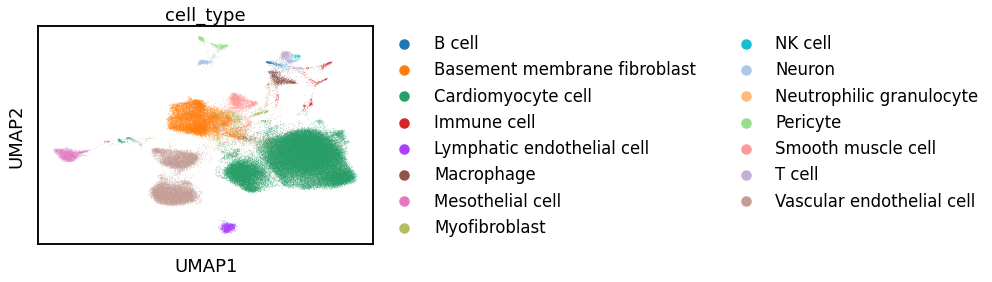

In [14]:
sc.pl.embedding(adata, basis='umap', color="cell_type", return_fig=False)

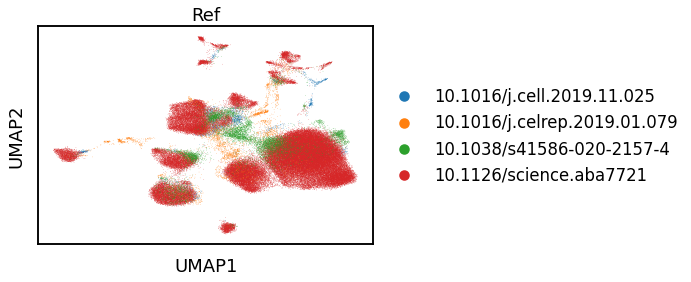

In [15]:
sc.pl.embedding(adata, basis='umap', color="Ref", return_fig=False)

### save coordinates and adata

In [16]:
adata.write('/data1/chenyx/Fetal.Heart.SCVI.h5ad')
#del adata

## 2. SCANVI

In [17]:
adata = ad_orig.copy()

### Integration

In [18]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(vae, 'Unknown')

/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [19]:
scanvi_model.train(25,use_gpu=False)

INFO     Training for 25 epochs.                                                             


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


Epoch 25/25: 100%|██████████| 25/25 [2:15:23<00:00, 324.93s/it, loss=3.06e+03, v_num=1]  


In [20]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [ ]:
scanvi_model.save("/data1/chenyx/scANVI_models/Fetal/", overwrite=True)

### calculate umap

In [21]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata,)

### visualization

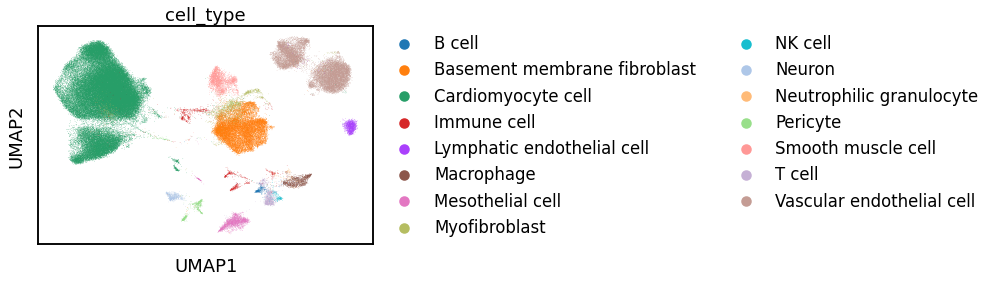

In [22]:
sc.pl.embedding(adata, basis='umap', color="cell_type", return_fig=False)

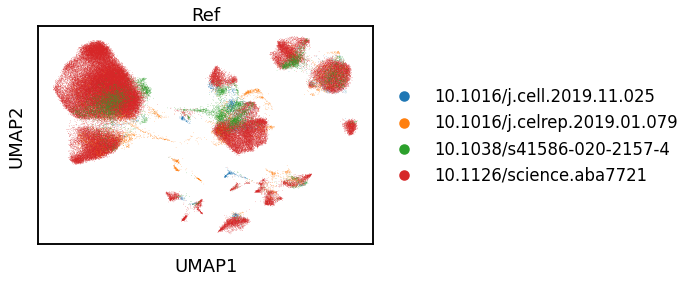

In [23]:
sc.pl.embedding(adata, basis='umap', color="Ref", return_fig=False)

### save

In [24]:
adata.write('/data1/chenyx/Fetal.Heart.SCANVI.h5ad')
#del adata

AAACCTGAGAAACCAT.1                                  Immune cell
AAACCTGGTGGTACAG.1                 Basement membrane fibroblast
AAACGGGAGATGTAAC.1                 Basement membrane fibroblast
AAACGGGAGGCAGTCA.1                 Basement membrane fibroblast
AAACGGGAGGTCATCT.1                 Basement membrane fibroblast
                                               ...             
FetalHeart_2.TTTAGGCTGTGTCACAAG                      Macrophage
FetalHeart_2.TTTAGGGCGTCCGAGATC                        Pericyte
FetalHeart_2.TTTAGGGGACATTGATCA              Cardiomyocyte cell
FetalHeart_2.TTTAGGTAGAGAAAGCGG              Cardiomyocyte cell
FetalHeart_2.TTTAGGTAGCATTCACTT       Vascular endothelial cell
Name: C_scANVI, Length: 117361, dtype: category
Categories (10, object): ['Basement membrane fibroblast', 'Cardiomyocyte cell', 'Immune cell', 'Macrophage', ..., 'Pericyte', 'Smooth muscle cell', 'T cell', 'Vascular endothelial cell']

In [50]:
df_1 = pd.DataFrame(adata.obsm['X_umap'])
df_2 = pd.DataFrame(adata.obs['C_scANVI'])
df_1.index = df_2.index

In [56]:
df = pd.concat([df_2,df_1],axis=1)
df.columns = ["cell_type","UMAP_1","UMAP_2"]

In [58]:
df.to_csv("Fetal.UMAP.csv")

In [52]:
adata = sc.read_h5ad("/data1/chenyx/Fetal.Heart.SCANVI.h5ad")

In [53]:
adata.obs.region = list(adata.obs.region.values)
adata.obs.region[adata.obs.region=='NA'] = "Heart"
adata.obs.region[adata.obs.region=='Aorta'] = "Blood vessel"
adata.obs.region[adata.obs.region=='Pulmonary artery'] = "Blood vessel"

/tmp/ipykernel_3804178/2569473478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.region[adata.obs.region=='NA'] = "Heart"
/tmp/ipykernel_3804178/2569473478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.region[adata.obs.region=='Aorta'] = "Blood vessel"
/tmp/ipykernel_3804178/2569473478.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.region[adata.obs.region=='Pulmonary artery'] = "Blood vesse

In [54]:
np.unique(adata.obs.region,return_counts=True)

(array(['Atria', 'Blood vessel', 'Heart', 'Valve', 'Ventricle'],
       dtype=object),
 array([  1608,    113, 113523,    499,   1618]))

In [55]:
adata.obs.subregion = list(adata.obs.subregion.values)

adata.obs.subregion[adata.obs.subregion=='Aortic valve'] = "Aorta"
#adata.obs.subregion[adata.obs.subregion=='NA'] = "Heart"
adata.obs.subregion[adata.obs.subregion=='Pulmonary valve'] = "Pulmonary artery"
adata.obs.subregion[adata.obs.subregion=='Ventricle'] = "NA"

/tmp/ipykernel_3804178/135158476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.subregion[adata.obs.subregion=='Aortic valve'] = "Aorta"
/tmp/ipykernel_3804178/135158476.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.subregion[adata.obs.subregion=='Pulmonary valve'] = "Pulmonary artery"
/tmp/ipykernel_3804178/135158476.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.subregion[adata.obs.subreg

In [56]:
np.unique(adata.obs.subregion,return_counts=True)

(array(['Aorta', 'Interventricular septum', 'Left atria', 'Left ventricle',
        'Mitral valve', 'NA', 'Pulmonary artery', 'Right atria',
        'Right ventricle', 'Tricuspid valve'], dtype=object),
 array([   167,     52,    773,    796,    124, 113545,    189,    835,
           748,    132]))

In [57]:
adata.obs.cell_type = list(adata.obs.cell_type.values)
adata.obs.cell_type[adata.obs.cell_type=="Immune cell"] = "Unknown"

adata.obs.C_scANVI = list(adata.obs.C_scANVI.values)
adata.obs.C_scANVI[adata.obs.C_scANVI=='Immune cell'] = 'Unknown'

/tmp/ipykernel_3804178/3239194232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.cell_type[adata.obs.cell_type=="Immune cell"] = "Unknown"


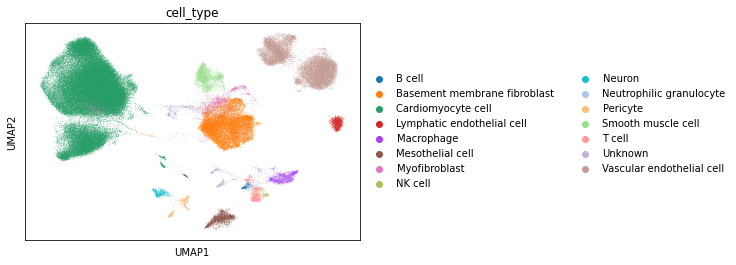

In [63]:
sc.pl.umap(adata,color='cell_type')

In [64]:
adata.write_h5ad("/data1/chenyx/Fetal.Heart.SCANVI.0707.h5ad")

In [67]:
adata

AnnData object with n_obs × n_vars = 117361 × 43878
    obs: 'cell_ID', 'donor_ID', 'donor_gender', 'donor_age', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'seq_tech', 'cell_type', 'if_patient', 'donor_status', 'treatment', 'ethnicity', 'Ref', 'MCT', 'develop_stage', 'PC_1', 'PC_2', 'TSNE_1', 'TSNE_2', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: '0'
    uns: 'Ref_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    obsp: 'connectivities', 'distances'